In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
class LayerInitializationStrategy:
    """Parent class for initialization strategies of weights and biases in Layer."""
    def run(self, size_of_previous_layer: int, size_of_current_layer: int) -> tuple[np.ndarray, np.ndarray]:
        raise NotImplementedError("The 'run' method is implemented only in child classes")

class RandomUniform(LayerInitializationStrategy):
    """
    Initialization strategy sampling weights and biases uniformly in a given interval.

    Attributes
    ----------
    scale: float
        The half-lenght of the interval [-scale, scale] from which values are sampled.

    Methods
    -------
    run(self, size_of_previous_layer: int, size_of_current_layer: int) -> tuple[np.ndarray, np.ndarray]
        Returns the tuple (random_weights, random_biases), where random_weights and random_biases are np.ndarrays of the appropriate shape.
    """
    def __init__(self, scale_of_interval: float):
        self.scale = scale_of_interval
    
    def run(self, size_of_previous_layer: int, size_of_current_layer: int) -> tuple[np.ndarray, np.ndarray]:
        random_weights: np.ndarray = np.random.uniform(
            -self.scale, self.scale,
            (size_of_previous_layer, size_of_current_layer)
            )
        random_biases: np.ndarray = np.random.uniform(
            -self.scale, self.scale,
            size_of_current_layer
            )
        return random_weights, random_biases

In [3]:
class ActivationFunction:
    """Parent class for activation functions of neural nodes."""
    def __call__(self, x: np.ndarray) -> np.ndarray:
        raise NotImplementedError("The '__call__' method must be implemented in child classes")

    def derivative(self, x: np.ndarray) -> np.ndarray:
        raise NotImplementedError("The 'derivative' method must be implemented in child classes")

class Sigmoid(ActivationFunction):
    """Sigmoid activation function. f(x) = 1 / (1 + np.exp(-x))"""
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-x))

    def derivative(self, x: np.ndarray) -> np.ndarray:
        sigmoid = self(x)  # Reuse the __call__ method to compute sigmoid
        return sigmoid * (1 - sigmoid)

In [4]:

class Layer:
    """
    A Layer component of a NeuralNetwork.

    Attributes
    ----------
    unit_number: int
        The number of nodes/units in the Layer.
    init_strat: LayerInitializationStrategy
        The initialization strategy for the weights and biases of the Layer
    activation_function: ActivationFunction
        The function.
    
    I should continue writing docstrings later
    """

    def __init__(self, number_of_units: int,
                 initialization_strategy: LayerInitializationStrategy,
                 activation_function: ActivationFunction):
        self.unit_number: int = number_of_units  # The number of nodes/units in the Layer.
        self.init_strat: LayerInitializationStrategy = initialization_strategy
        self.activation_function: ActivationFunction = activation_function
        self.linear_output: np.ndarray = None
        self.output: np.ndarray = None  # The values computed by the units based on the outputs of the previous layer. Stored for later backprop.
        self.previous_layer: Layer = None  # The layer preceding the current one in the Neural Network. The NN should connect layers during initialization.
        self.next_layer: Layer = None
        self.weights: np.ndarray = None; self.biases: np.ndarray = None  # Weights and biases connecting the layer with the previous layer of the neural network.
        self.delta: np.ndarray = None
        

    def initialize_weights(self):
        self.weights, self.biases = self.init_strat.run(self.previous_layer.unit_number, self.unit_number)

    def compute_output(self):
        self.linear_output = np.dot(self.previous_layer.output, self.weights) + self.biases
        self.output: np.ndarray = self.activation_function(self.linear_output)
        return self.output
    
    # def compute_gradient(self)  # Should this function be here or in a later TrainingAlgorithm class?

class InputLayer(Layer):
    def __init__(self, number_of_units: int):
        super().__init__(number_of_units, None, None)
        # An input layer has no previous layer to connect to, so attributes referring to a previous layer are deleted.
        del self.previous_layer, self.weights, self.biases, self.init_strat, self.activation_function
    
    def feed_input(self, value: np.ndarray) -> None:
        self.output: np.ndarray = value
    
    def initialize_weights(self):
        raise NotImplementedError("InputLayer does not require weight initialization.")

    def compute_output(self):
        return self.output

class HiddenLayer(Layer):
    pass

class OutputLayer(Layer):
    def __init__(self, number_of_units: int,
                 initialization_strategy: LayerInitializationStrategy,
                 activation_function: ActivationFunction):
        super().__init__(number_of_units, initialization_strategy, activation_function)
        del self.next_layer

In [5]:
class NeuralNetwork:
    def __init__(self, layers: list[Layer]):
        self.layers: list[Layer] = layers
        # Maybe here I should ensure that layers are correctly typed (layers[0] should be an InputLayer, layers[-1] an OutputLayer, all other layers should be HiddenLayer).
        self.input_layer: InputLayer = layers[0]; self.hidden_layers: list[HiddenLayer] = layers[1: -1]; self.output_layer: OutputLayer = layers[-1]
        self.layers_with_weights: list[Layer] = self.layers[1: ]
        self.connect_layers()
        self.initialize_weights()
    
    def connect_layers(self) -> None:
        for (i, layer) in enumerate(self.layers):
            if not isinstance(layer, InputLayer): layer.previous_layer = self.layers[i - 1]
            if not isinstance(layer, OutputLayer): layer.next_layer = self.layers[i + 1]

    def initialize_weights(self) -> None:
        
        for layer in self.layers_with_weights: layer.initialize_weights()
    
    def feed_input(self, value: np.ndarray) -> None:
        self.input_layer.feed_input(value)

    def activate_network(self) -> np.ndarray:
        for i in range(len(self.layers)): self.layers[i].compute_output()
        return self.output_layer.output
    
    def compute_output(self, value: np.ndarray) -> np.ndarray:
        self.feed_input(value)
        return self.activate_network()
    
    def compute_multiple_outputs(self, x_data: pd.DataFrame | np.ndarray) -> np.ndarray[np.ndarray]:
        if isinstance(x_data, pd.DataFrame): x_data = x_data.to_numpy()
        outputs = np.array(
            [
                self.compute_output(x_data[i]) for i in range(len(x_data))
            ]
        )
        return outputs

In [6]:
class LossFunction:
    def __call__(self, y_data: np.ndarray, y_predicted: np.ndarray) -> float:
        pass
    
    def simple_gradient(self, y_data: np.ndarray, y_predicted: np.ndarray) -> np.ndarray:
        pass

class MSE(LossFunction):
    def __call__(self, y_data: np.ndarray, y_predicted: np.ndarray) -> float:
        return 0.5 * np.sum((y_data - y_predicted)**2) / len(y_data)
    
    def simple_gradient(self, y_data: np.ndarray, y_predicted: np.ndarray) -> np.ndarray:
        return (y_data - y_predicted)


class RegularizationTerm:
    def set_network(self, network: NeuralNetwork) -> None:
        self.network = network

    def __call__(self) -> float:
        pass

    def gradient(self) -> tuple[list[np.ndarray], list[np.ndarray]]:
        pass

class NoRegularization(RegularizationTerm):
    def __init__(self):
        pass

    def __call__(self) -> float:
        return 0
    
    def gradient(self) -> tuple[list[np.ndarray], list[np.ndarray]]:
        layers = self.network.layers_with_weights
        return [np.zeros_like(l.weights) for l in layers], [np.zeros_like(l.biases) for l in layers]

class Tikhonov(RegularizationTerm):
    def __init__(self, penalty: float):
        self.penalty: float = penalty
        self.network: NeuralNetwork = None

    def __call__(self) -> float:
        weights_term = np.sum([np.sum(layer.weigths**2) for layer in self.network.layers_with_weights])  # The sum of squares of all the weights in the NN.
        biases_term = np.sum([np.sum(layer.biases**2) for layer in self.network.layers_with_weights])
        return self.penalty * (weights_term + biases_term) / 2

    def gradient(self) -> tuple[list[np.ndarray], list[np.ndarray]]:
        layers: list[Layer] = self.network.layers_with_weights
        gradient_on_weights: list[np.ndarray] = [-self.penalty * l.weights for l in layers]
        gradient_on_biases: list[np.ndarray] = [-self.penalty * l.biases for l in layers]
        return gradient_on_weights, gradient_on_biases


class MomentumRule:
    pass


class StoppingCondition:
    def is_satisfied(self, loss: float, gradients: np.ndarray = None) -> bool:
        raise NotImplementedError("This method is only implemented in child classes")

class ThresholdOnLoss(StoppingCondition):
    def __init__(self, threshold: float, patience: int):
        self.threshold = threshold; self.patience = patience
        self.consecutive_epochs = 0
    
    def is_satisfied(self, loss: float, gradients: np.ndarray = None) -> bool:
        if loss < self.threshold:
            self.consecutive_epochs += 1
            return self.consecutive_epochs > self.patience
        else:
            self.consecutive_epochs = 0
            return False



def sum_lists(list1: list[np.ndarray], list2: list[np.ndarray]) -> list[np.ndarray]:
    return [x + y for x, y in zip(list1, list2)]

class TrainingStrategy:
    def __init__(self, x_data: pd.DataFrame, y_data: pd.DataFrame, network: NeuralNetwork):
        self.x = x_data.to_numpy(); self.y = y_data.to_numpy()
        self.network = network
        self.history: list[dict] = []

class SimpleBackpropagationAlgorithm(TrainingStrategy):
    def __init__(self, x_data: pd.DataFrame, y_data: pd.DataFrame, network: NeuralNetwork,
                 learning_rate: float,
                 loss_function: LossFunction, stopping_condition: StoppingCondition,
                 regularization_term: RegularizationTerm = None
                 ):
        super().__init__(x_data, y_data, network)
        self.learning_rate = learning_rate
        self.loss: LossFunction = loss_function
        self.stop_cond: StoppingCondition = stopping_condition

        self.weights_gradient: list[np.ndarray] = None
        self.biases_gradient: list[np.ndarray] = None

        
        self.regularization_term: RegularizationTerm = regularization_term or NoRegularization()
        self.regularization_term.set_network(self.network)

    def run(self, max_epochs: int) -> None:
        """
        Train the NeuralNetwork according to this strategy.
        """
        epoch: int = 0
        network_outputs: np.ndarray = self.network.compute_multiple_outputs(self.x)
        current_loss: float = self.loss(self.y, network_outputs)
        while not self.stop_cond.is_satisfied(current_loss, None) and epoch < max_epochs:
            epoch += 1
            self.update_gradients()
            self.update_network_weights()
            network_outputs: np.ndarray = self.network.compute_multiple_outputs(self.x)
            current_loss = self.loss(self.y, network_outputs)
            self.history += [{'loss': current_loss}]

    def compute_loss(self) -> float:
        network_outputs: np.ndarray = self.network.compute_multiple_outputs(self.x)
        return self.loss(self.y, network_outputs) + self.regularization_term()

    def update_gradients(self) -> None:
        """
        Computes the gradients for the weights and the biases, on the whole batch.
        """
        lwws: list[Layer] = self.network.layers_with_weights
        self.weights_gradient = [np.zeros_like(l.weights) for l in lwws]; self.biases_gradient = [np.zeros_like(l.biases) for l in lwws]  # Reset gradients
        for i in range(len(self.x)):  # For each pattern:
            w_grad_contribution, b_grad_contribution = self.compute_single_pattern_gradient(i)  # Compute the single-pattern gradients.
            self.weights_gradient = [old + new for old, new in zip(self.weights_gradient, w_grad_contribution)]  # Update whole-batch gradients by summing the lists element-wise.
            self.biases_gradient = [old + new for old, new in zip(self.biases_gradient, b_grad_contribution)]
        
        weights_regularization_term, biases_regularization_term = self.regularization_term.gradient()
        self.weights_gradient = [element + reg_term for element, reg_term in zip(self.weights_gradient, weights_regularization_term)]
        self.biases_gradient = [element + reg_term for element, reg_term in zip(self.biases_gradient, biases_regularization_term)]
        # self.weights_gradient = [element/len(self.x) for element in self.weights_gradient]  # Divide by the number of patterns to get the average
        # self.biases_gradient = [element/len(self.x) for element in self.biases_gradient]

    def compute_single_pattern_gradient(self, index: int) -> tuple[list[np.ndarray], list[np.ndarray]]:
        """
        Computes the gradients for the weights and the biases, which should be used to update
        the weights and biases of the Network in order to nudge its output for a given pattern towards the correct value.

        Parameters
        ----------
        index: int
            The index of the relevant pattern.
        
        Returns
        -------
        w_grad: list[np.ndarray]
            The gradient for the weights.
        b_grad: list[np.ndarray]
            The gradient for the biases.
        """
        self.backpropagate(index)
        w_grad = [
            np.outer(l.previous_layer.output, l.delta) for l in self.network.layers_with_weights
        ]
        b_grad = [
            l.delta for l in self.network.layers_with_weights
        ]

        return w_grad, b_grad

    def backpropagate(self, index) -> None:
        """
        Computes the quantities named "delta" for a given pattern for each node of the NeuralNetwork,
        starting from the OutputLayer and proceeding backwards, and saving them in the Layer objects.

        Parameters
        ----------
        index: int
            The index of the relevant pattern.
        """
        self.network.compute_output(self.x[index])  # Prepare the Network by runing the pattern through it, so that each node stores its output.
        out_l: OutputLayer = self.network.output_layer; hid_ls: list[HiddenLayer] = self.network.hidden_layers  # Give short, convenient names to the OutputLayer and the HiddenLayers.

        out_l.delta = out_l.activation_function.derivative(out_l.linear_output) * self.loss.simple_gradient(self.y[index], out_l.output)  # Compute delta for the OutputLayer.
        for l in reversed(hid_ls):  # For each HiddenLayer, starting from the one closest to the OutputLayer and proceeding backwards:
            l.delta = l.activation_function.derivative(l.linear_output) * np.dot(l.next_layer.weights, l.next_layer.delta)  # Compute delta for the HiddenLayer.

    def update_network_weights(self) -> None:
        """
        Updates the weights and biases of the NeuralNetwork based on the computed gradients.
        """
        for i, l in enumerate(self.network.layers_with_weights):
            l.weights += self.learning_rate * self.weights_gradient[i]   
            l.biases += self.learning_rate * self.biases_gradient[i]




# Test code correctness

In [7]:
import os

monk2train_path = os.path.join('..', 'monk+s+problems', 'monks-2.train')
df = pd.read_csv(monk2train_path, sep = ' ', skipinitialspace= True, names= ['class', 'a1','a2','a3','a4','a5','a6', 'ID'])
raw_x = df.loc[:, 'a1':'a6']; raw_y = df.loc[:, 'class']
x = pd.get_dummies(raw_x, columns = raw_x.columns).astype(int); y = pd.get_dummies(raw_y).astype(int)

In [8]:
display(x, y)

,a1_1,a1_2,a1_3,a2_1,a2_2,a2_3,a3_1,a3_2,a4_1,a4_2,a4_3,a5_1,a5_2,a5_3,a5_4,a6_1,a6_2
0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1
1,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,0
2,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0
3,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1
4,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,1,0
165,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,1
166,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0
167,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0


,0,1
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
164,1,0
165,1,0
166,0,1
167,1,0


In [24]:
initialization_strategy = RandomUniform(0.3)
il = InputLayer(17)
hl = HiddenLayer(6, initialization_strategy, Sigmoid())
hl2 = HiddenLayer(6, initialization_strategy, Sigmoid())
ol = OutputLayer(2, RandomUniform(0.5), Sigmoid())

nn = NeuralNetwork([il, hl, ol])


trainer = SimpleBackpropagationAlgorithm(
    x, y, nn, 0.10, MSE(), ThresholdOnLoss(0.001, 5), Tikhonov(0.18)
)


In [25]:
trainer.run(1000)

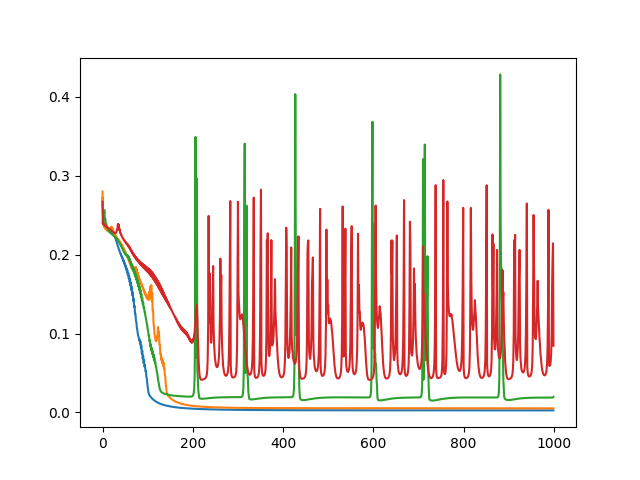

In [26]:
plot_history = [trainer.history[i]['loss'] for i in range(len(trainer.history))]
plt.plot(plot_history)
plt.show()

In [14]:
plt.close()

In [71]:
trainer.y - nn.compute_multiple_outputs(x)

array([[ 0.34172653, -0.34172653],
       [ 0.17813789, -0.17813789],
       [ 0.25584995, -0.25584995],
       [ 0.32687901, -0.32687901],
       [ 0.3704637 , -0.3704637 ],
       [ 0.29705982, -0.29705982],
       [ 0.24723873, -0.24723873],
       [ 0.39674541, -0.39674541],
       [ 0.2681944 , -0.2681944 ],
       [ 0.17981941, -0.17981941],
       [ 0.2315456 , -0.2315456 ],
       [ 0.29603654, -0.29603654],
       [ 0.24613943, -0.24613943],
       [-0.68447673,  0.68447673],
       [ 0.34951761, -0.34951761],
       [-0.53644885,  0.53644885],
       [ 0.29270396, -0.29270396],
       [ 0.39950205, -0.39950205],
       [-0.48729863,  0.48729863],
       [ 0.36812491, -0.36812491],
       [-0.55557364,  0.55557364],
       [ 0.31058682, -0.31058682],
       [ 0.34494723, -0.34494723],
       [ 0.42508859, -0.42508859],
       [-0.46705065,  0.46705065],
       [ 0.39409771, -0.39409771],
       [-0.53203849,  0.53203849],
       [ 0.33552607, -0.33552607],
       [-0.58621624,

In [72]:
print(trainer.history[0]['loss'])
print(trainer.history[-1]['loss'])

0.22644072055816541
0.21907450099427367


In [73]:
nn.compute_multiple_outputs(x)

array([[0.65827347, 0.34172653],
       [0.82186211, 0.17813789],
       [0.74415005, 0.25584995],
       [0.67312099, 0.32687901],
       [0.6295363 , 0.3704637 ],
       [0.70294018, 0.29705982],
       [0.75276127, 0.24723873],
       [0.60325459, 0.39674541],
       [0.7318056 , 0.2681944 ],
       [0.82018059, 0.17981941],
       [0.7684544 , 0.2315456 ],
       [0.70396346, 0.29603654],
       [0.75386057, 0.24613943],
       [0.68447673, 0.31552327],
       [0.65048239, 0.34951761],
       [0.53644885, 0.46355115],
       [0.70729604, 0.29270396],
       [0.60049795, 0.39950205],
       [0.48729863, 0.51270137],
       [0.63187509, 0.36812491],
       [0.55557364, 0.44442636],
       [0.68941318, 0.31058682],
       [0.65505277, 0.34494723],
       [0.57491141, 0.42508859],
       [0.46705065, 0.53294935],
       [0.60590229, 0.39409771],
       [0.53203849, 0.46796151],
       [0.66447393, 0.33552607],
       [0.58621624, 0.41378376],
       [0.6677319 , 0.3322681 ],
       [0.

In [79]:
trainer.stop_cond.threshold = 0.001
trainer.run(1000)

In [80]:
outputs = nn.compute_multiple_outputs(x)
predictions = np.array([
    0 if outputs[i][0] > outputs[i][1] else 1 for i in range(len(x))
])
actual_values = y.loc[:, 1].to_numpy()
print(f"Fraction of correct predictions = {(actual_values == predictions).sum() / len(y)}")

Fraction of correct predictions = 1.0


In [68]:
print(np.sum(
    [np.sum(l.weights**2) for l in nn.layers_with_weights]
),
np.sum(
    [np.sum(l.biases**2) for l in nn.layers_with_weights]
)
)

4.0562492138551125 0.034722208212944916
